In [1]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import VectorIndexer
import numpy as np

In [ ]:
# Inisialisasi Spark Session
spark = SparkSession.builder \
    .appName("StudentStressAnalysis") \
    .getOrCreate()

In [ ]:
# Definisi schema
schema = StructType([
    StructField("Student_ID", IntegerType(), True),
    StructField("Study_Hours_Per_Day", DoubleType(), True),
    StructField("Extracurricular_Hours_Per_Day", DoubleType(), True),
    StructField("Sleep_Hours_Per_Day", DoubleType(), True),
    StructField("Social_Hours_Per_Day", DoubleType(), True),
    StructField("Physical_Activity_Hours_Per_Day", DoubleType(), True),
    StructField("GPA", DoubleType(), True),
    StructField("Stress_Level", StringType(), True)
])

In [ ]:
# Membaca data dari CSV
df = spark.read.csv('/content/student_lifestyle_dataset.csv', header=True, schema=schema)

In [ ]:
df.show()
df.describe()

+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+----+------------+
|Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Social_Hours_Per_Day|Physical_Activity_Hours_Per_Day| GPA|Stress_Level|
+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+----+------------+
|         1|                6.9|                          3.8|                8.7|                 2.8|                            1.8|2.99|    Moderate|
|         2|                5.3|                          3.5|                8.0|                 4.2|                            3.0|2.75|         Low|
|         3|                5.1|                          3.9|                9.2|                 1.2|                            4.6|2.67|         Low|
|         4|                6.5|                          2.1|              

DataFrame[summary: string, Student_ID: string, Study_Hours_Per_Day: string, Extracurricular_Hours_Per_Day: string, Sleep_Hours_Per_Day: string, Social_Hours_Per_Day: string, Physical_Activity_Hours_Per_Day: string, GPA: string, Stress_Level: string]

=== Tipe Data Awal ===
root
 |-- Student_ID: integer (nullable = true)
 |-- Study_Hours_Per_Day: double (nullable = true)
 |-- Extracurricular_Hours_Per_Day: double (nullable = true)
 |-- Sleep_Hours_Per_Day: double (nullable = true)
 |-- Social_Hours_Per_Day: double (nullable = true)
 |-- Physical_Activity_Hours_Per_Day: double (nullable = true)
 |-- GPA: double (nullable = true)
 |-- Stress_Level: string (nullable = true)


Jumlah baris: 2000
Jumlah kolom: 8

=== Nama Kolom Setelah Diubah ===
Kolom: ['id_siswa', 'jam_belajar', 'jam_ekstrakurikuler', 'jam_tidur', 'jam_sosial', 'jam_aktivitas_fisik', 'ipk', 'tingkat_stres']

=== Pemeriksaan Nilai Null ===
+--------+-----------+-------------------+---------+----------+-------------------+---+-------------+
|id_siswa|jam_belajar|jam_ekstrakurikuler|jam_tidur|jam_sosial|jam_aktivitas_fisik|ipk|tingkat_stres|
+--------+-----------+-------------------+---------+----------+-------------------+---+-------------+
|       0|          0|        

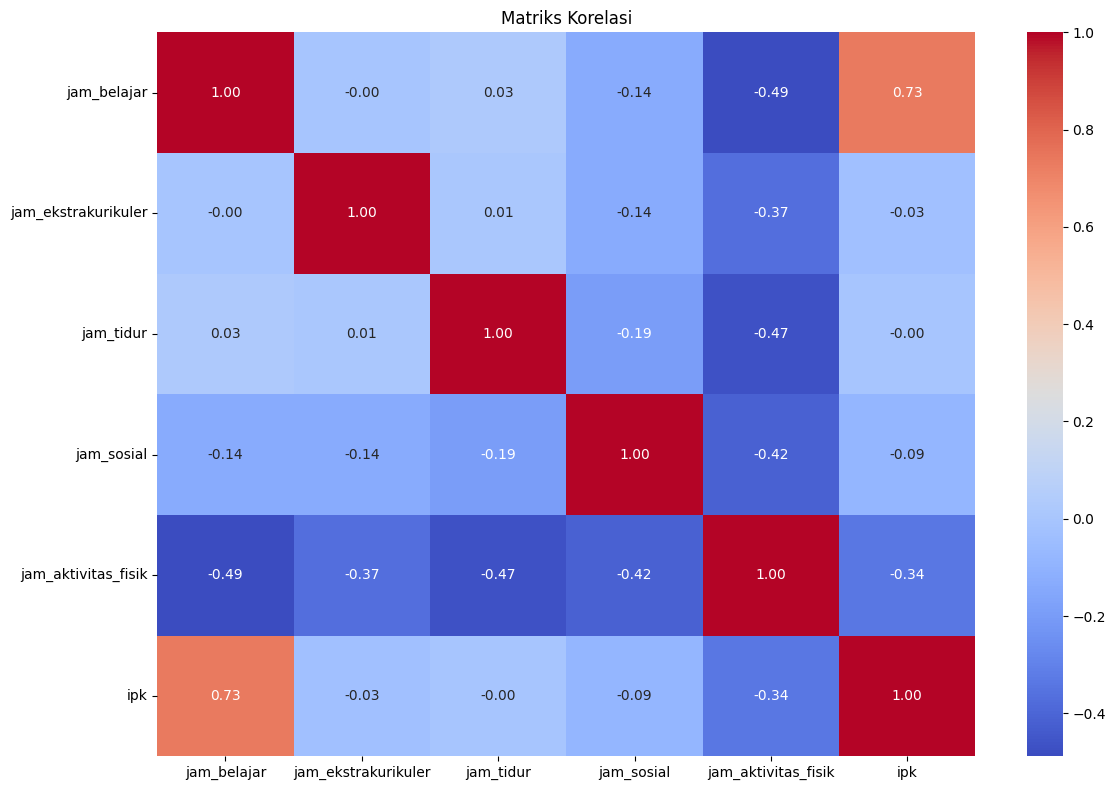


=== Matriks Korelasi ===
                     jam_belajar  jam_ekstrakurikuler  jam_tidur  jam_sosial  jam_aktivitas_fisik   ipk
jam_belajar                 1.00                -0.00       0.03       -0.14                -0.49  0.73
jam_ekstrakurikuler        -0.00                 1.00       0.01       -0.14                -0.37 -0.03
jam_tidur                   0.03                 0.01       1.00       -0.19                -0.47 -0.00
jam_sosial                 -0.14                -0.14      -0.19        1.00                -0.42 -0.09
jam_aktivitas_fisik        -0.49                -0.37      -0.47       -0.42                 1.00 -0.34
ipk                         0.73                -0.03      -0.00       -0.09                -0.34  1.00


In [ ]:
# 1. PREPROCESSING DATA

# a) Menampilkan tipe data awal
print("=== Tipe Data Awal ===")
df.printSchema()
print("\nJumlah baris:", df.count())
print("Jumlah kolom:", len(df.columns))

# b) Mengganti nama kolom
df = df.withColumnRenamed("Student_ID", "id_siswa") \
    .withColumnRenamed("Study_Hours_Per_Day", "jam_belajar") \
    .withColumnRenamed("Extracurricular_Hours_Per_Day", "jam_ekstrakurikuler") \
    .withColumnRenamed("Sleep_Hours_Per_Day", "jam_tidur") \
    .withColumnRenamed("Social_Hours_Per_Day", "jam_sosial") \
    .withColumnRenamed("Physical_Activity_Hours_Per_Day", "jam_aktivitas_fisik") \
    .withColumnRenamed("GPA", "ipk") \
    .withColumnRenamed("Stress_Level", "tingkat_stres")

print("\n=== Nama Kolom Setelah Diubah ===")
print("Kolom:", df.columns)

# c) Memeriksa nilai null
print("\n=== Pemeriksaan Nilai Null ===")
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

# d) Mengubah tipe data untuk processing
# Convert tingkat_stres ke numeric menggunakan StringIndexer
indexer = StringIndexer(inputCol="tingkat_stres", outputCol="label", handleInvalid="keep")
df_indexed = indexer.fit(df).transform(df)

# Membuat vector feature
feature_cols = ["jam_belajar", "jam_ekstrakurikuler", "jam_tidur",
                "jam_sosial", "jam_aktivitas_fisik", "ipk"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_processed = assembler.transform(df_indexed)

print("\n=== Tipe Data Setelah Transformasi ===")
df_processed.printSchema()

# e) Menampilkan summary statistik
print("\n=== Summary Statistik ===")
df.summary().show()

# f) Menampilkan matriks korelasi
# Convert ke pandas untuk perhitungan korelasi
pdf = df.select(feature_cols).toPandas()
correlation_matrix = pdf.corr()

# Visualisasi matriks korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriks Korelasi')
plt.tight_layout()
plt.show()

print("\n=== Matriks Korelasi ===")
print(correlation_matrix.round(2).to_string())

In [ ]:
# Menyimpan DataFrame yang sudah diproses untuk modeling
df_final = df_processed.select("label", "features")

print("\n=== Sample Data Hasil Processing ===")
df_final.show(5)


=== Sample Data Hasil Processing ===
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[6.9,3.8,8.7,2.8,...|
|  2.0|[5.3,3.5,8.0,4.2,...|
|  2.0|[5.1,3.9,9.2,1.2,...|
|  1.0|[6.5,2.1,7.2,1.7,...|
|  0.0|[8.1,0.6,6.5,2.2,...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
# Convert to pandas for visualization
pdf = df.toPandas()

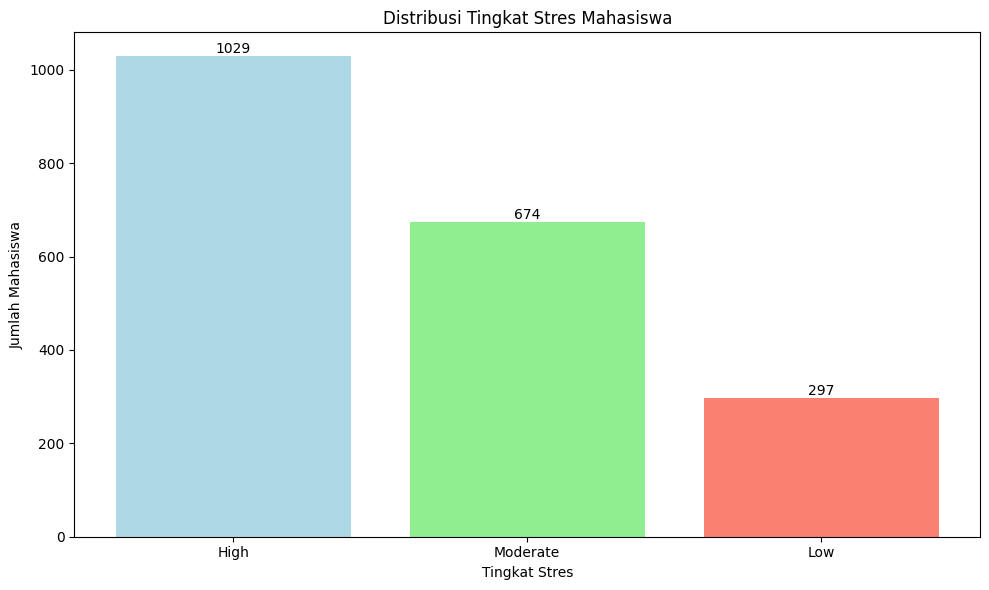

In [ ]:
# Bar Chart - Distribusi Tingkat Stres
plt.figure(figsize=(10, 6))
stress_counts = pdf['tingkat_stres'].value_counts()
plt.bar(stress_counts.index, stress_counts.values, color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Distribusi Tingkat Stres Mahasiswa')
plt.xlabel('Tingkat Stres')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=0)
for i, v in enumerate(stress_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

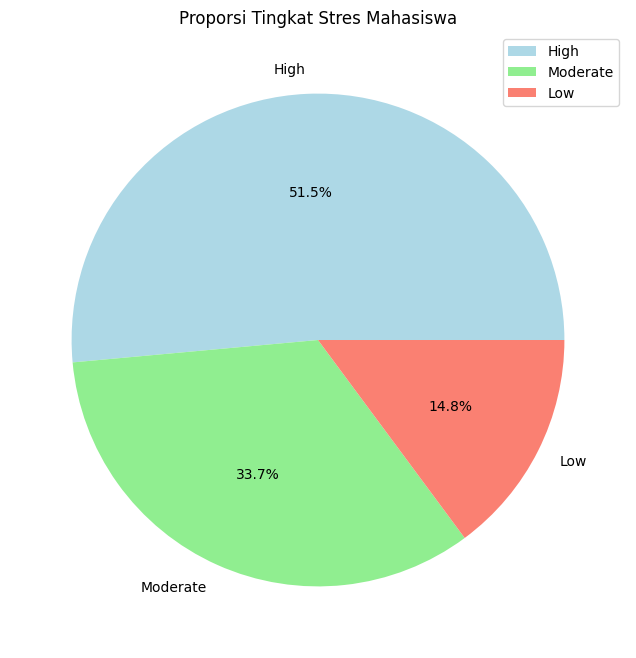

In [ ]:
# Pie Chart - Proporsi Tingkat Stres
plt.figure(figsize=(10, 8))
plt.pie(stress_counts.values, labels=stress_counts.index, autopct='%1.1f%%',
        colors=['lightblue', 'lightgreen', 'salmon'])
plt.title('Proporsi Tingkat Stres Mahasiswa')
plt.legend()
plt.show()

<ipython-input-22-80ec1749bf83>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tingkat_stres', y='ipk', data=pdf, palette='Set3')


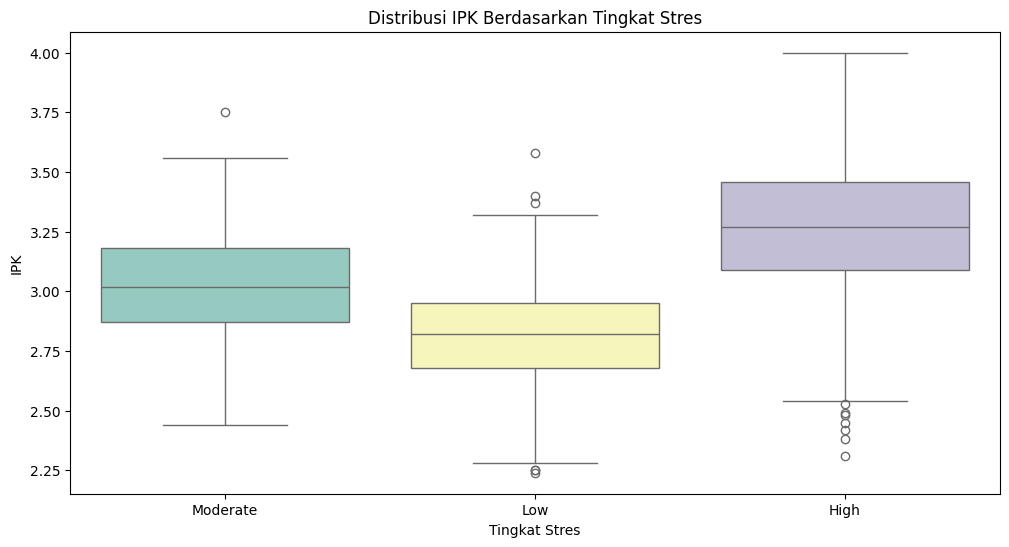

In [ ]:
# Box Plot - Distribusi IPK berdasarkan Tingkat Stres
plt.figure(figsize=(12, 6))
sns.boxplot(x='tingkat_stres', y='ipk', data=pdf, palette='Set3')
plt.title('Distribusi IPK Berdasarkan Tingkat Stres')
plt.xlabel('Tingkat Stres')
plt.ylabel('IPK')
plt.show()


<Figure size 1500x1500 with 0 Axes>

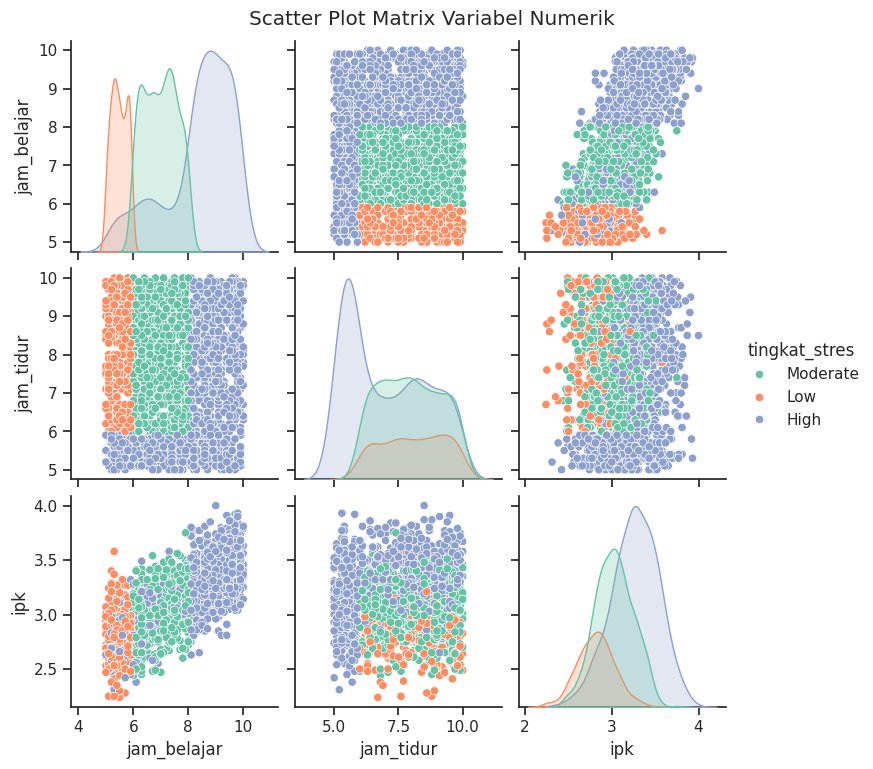

In [ ]:
# Scatter Plot Matrix untuk variabel numerik
sns.set(style="ticks")
plt.figure(figsize=(15, 15))
numeric_cols = ['jam_belajar', 'jam_tidur', 'ipk']
sns.pairplot(pdf, vars=numeric_cols, hue='tingkat_stres', palette='Set2')
plt.suptitle('Scatter Plot Matrix Variabel Numerik', y=1.02)
plt.show()

In [ ]:
# Label encoding
indexer = StringIndexer(inputCol="tingkat_stres", outputCol="label")
df_indexed = indexer.fit(df).transform(df)

In [ ]:
df.show()

+--------+-----------+-------------------+---------+----------+-------------------+----+-------------+
|id_siswa|jam_belajar|jam_ekstrakurikuler|jam_tidur|jam_sosial|jam_aktivitas_fisik| ipk|tingkat_stres|
+--------+-----------+-------------------+---------+----------+-------------------+----+-------------+
|       1|        6.9|                3.8|      8.7|       2.8|                1.8|2.99|     Moderate|
|       2|        5.3|                3.5|      8.0|       4.2|                3.0|2.75|          Low|
|       3|        5.1|                3.9|      9.2|       1.2|                4.6|2.67|          Low|
|       4|        6.5|                2.1|      7.2|       1.7|                6.5|2.88|     Moderate|
|       5|        8.1|                0.6|      6.5|       2.2|                6.6|3.51|         High|
|       6|        6.0|                2.1|      8.0|       0.3|                7.6|2.85|     Moderate|
|       7|        8.0|                0.7|      5.3|       5.7|          

In [ ]:
# Feature selection
feature_cols = ["jam_belajar", "jam_ekstrakurikuler", "jam_tidur",
                "jam_sosial", "jam_aktivitas_fisik", "ipk"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_final = assembler.transform(df_indexed).select("features", "label")


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import (
    GBTClassifier, OneVsRest, RandomForestClassifier,
    DecisionTreeClassifier, MultilayerPerceptronClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
# Persiapan data
# Split data
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Initialize models
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", layers=[len(feature_cols), 10, 3], seed=42)

# One-vs-Rest for GBT
ovr_gbt = OneVsRest(classifier=gbt, labelCol="label", featuresCol="features")

models = {
    "Random Forest": rf,
    "Gradient Boosting Tree (OvR)": ovr_gbt,
    "Decision Tree": dt,
    "Multilayer Perceptron": mlp
}


In [ ]:
# Initialize evaluators
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator_binary = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Dictionary for results
results = {}



Evaluating model: Random Forest

Confusion Matrix for Random Forest:
prediction  0.0  1.0  2.0
label                    
0.0         190    0    0
1.0           4  119    0
2.0           1    0   44


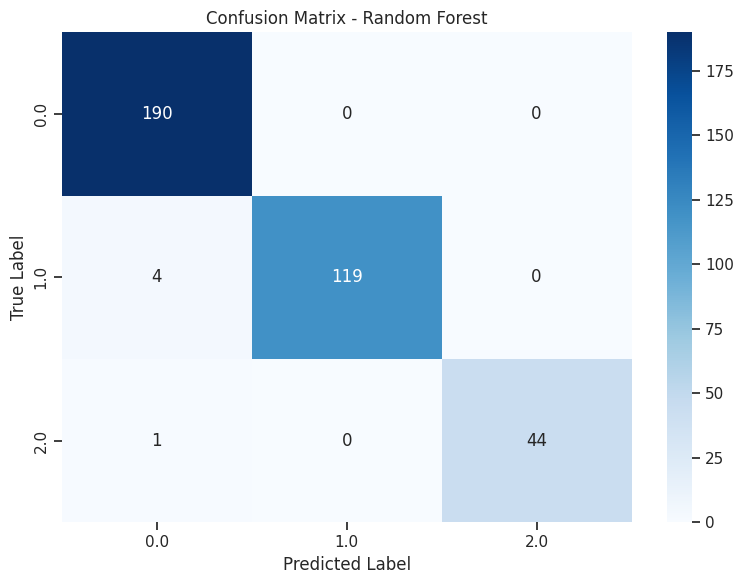


Evaluating model: Gradient Boosting Tree (OvR)

Confusion Matrix for Gradient Boosting Tree (OvR):
prediction  0.0  1.0  2.0
label                    
0.0         190    0    0
1.0           3  120    0
2.0           1    0   44


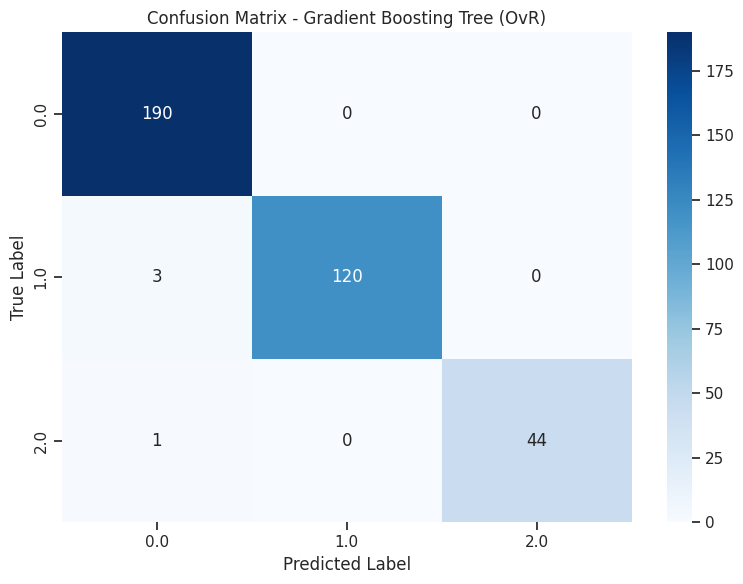


Evaluating model: Decision Tree

Confusion Matrix for Decision Tree:
prediction  0.0  1.0  2.0
label                    
0.0         190    0    0
1.0           3  120    0
2.0           1    0   44


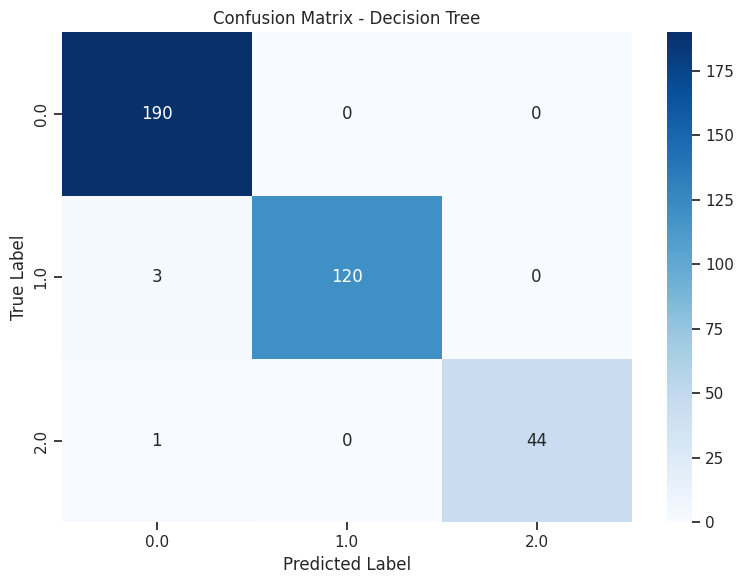


Evaluating model: Multilayer Perceptron

Confusion Matrix for Multilayer Perceptron:
prediction  0.0  1.0  2.0
label                    
0.0         189    1    0
1.0           0  123    0
2.0           0    0   45


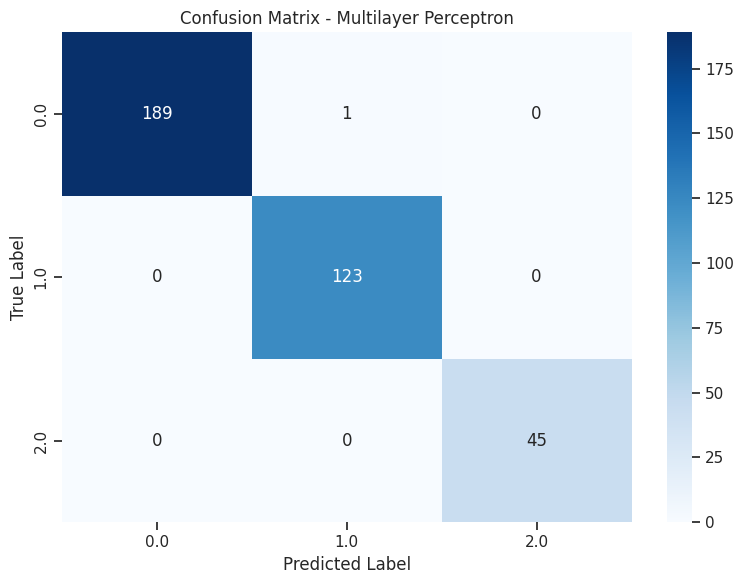

In [ ]:
# Train and evaluate models
for name, model in models.items():
    print(f"\nEvaluating model: {name}")

    # Train model
    model_fitted = model.fit(train_data)
    predictions = model_fitted.transform(test_data)

    # Calculate metrics
    accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
    f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)
    precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)

    # Calculate AUC if applicable
    try:
        auc = evaluator_binary.evaluate(predictions)
    except Exception:
        auc = np.nan

    results[name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc
    }

    # Confusion Matrix
    predictions_pd = predictions.select("label", "prediction").toPandas()
    cm = pd.crosstab(predictions_pd['label'], predictions_pd['prediction'])
    print(f"\nConfusion Matrix for {name}:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [ ]:
# Display results
results_df = pd.DataFrame(results).T.round(3)
print("\n=== Model Comparison ===")
print(results_df)



=== Model Comparison ===
                              Accuracy  F1 Score  Precision  Recall    AUC
Random Forest                    0.986     0.986      0.986   0.986    NaN
Gradient Boosting Tree (OvR)     0.989     0.989      0.989   0.989  0.889
Decision Tree                    0.989     0.989      0.989   0.989    NaN
Multilayer Perceptron            0.997     0.997      0.997   0.997    NaN


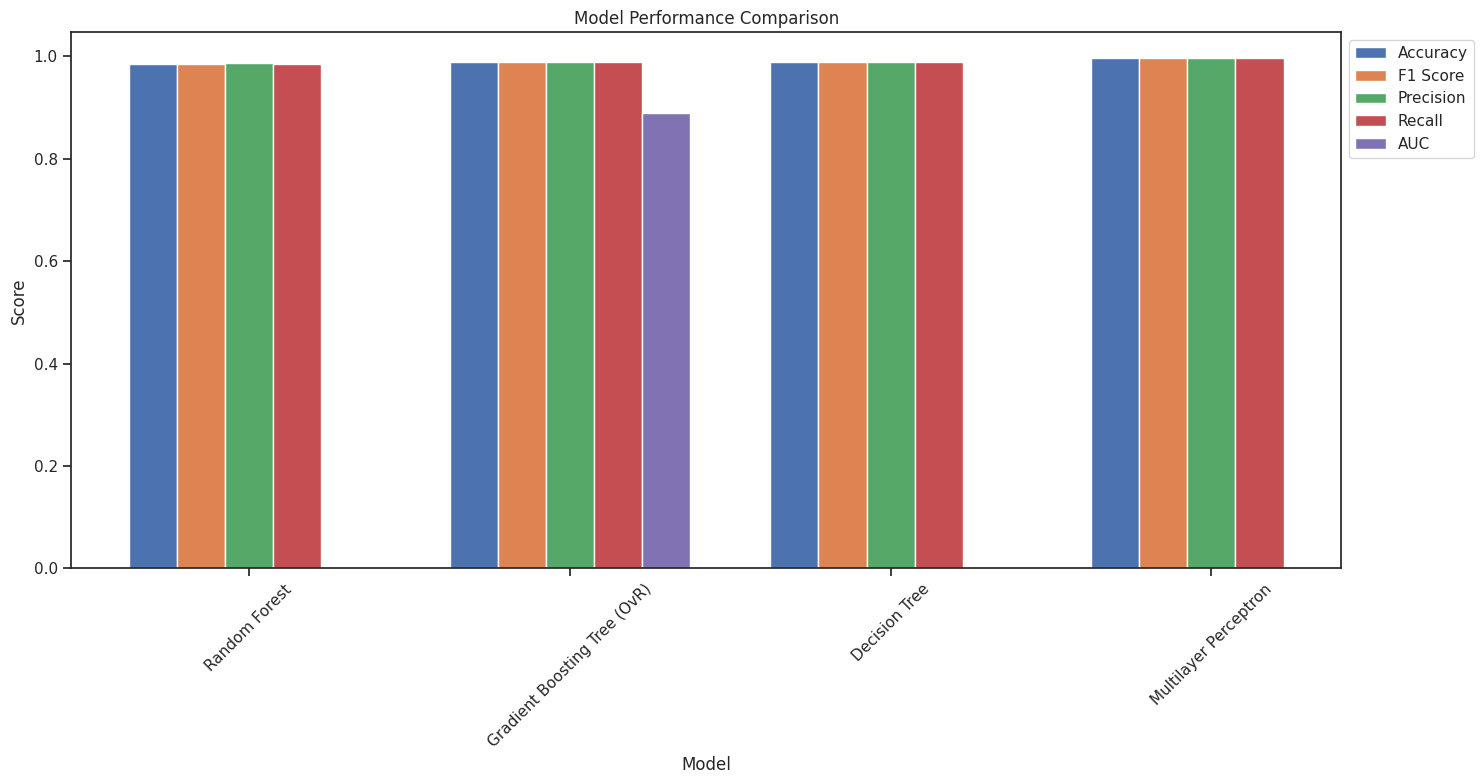

In [ ]:
# Visualize results
metrics = ["Accuracy", "F1 Score", "Precision", "Recall", "AUC"]
model_names = list(results.keys())

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.15
multiplier = 0

for metric in metrics:
    metric_values = [results[model].get(metric, 0) for model in model_names]
    offset = width * multiplier
    plt.bar(x + offset, metric_values, width, label=metric)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width * 2, model_names, rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# One-vs-Rest dengan GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
ovr_gbt = OneVsRest(classifier=gbt, labelCol="label", featuresCol="features")

# Hyperparameter tuning menggunakan ParamGridBuilder
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.maxDepth, [5, 7, 10]) \
    .build()

# CrossValidator setup
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cross_val = CrossValidator(estimator=ovr_gbt,
                           estimatorParamMaps=gbt_param_grid,
                           evaluator=evaluator,
                           numFolds=3)


In [ ]:
# Melakukan fit model
cv_gbt_model = cross_val.fit(train_data)

In [ ]:
# Model terbaik
gbt_best_model = cv_gbt_model.bestModel

In [ ]:
# Evaluasi pada test set
gbt_predictions = gbt_best_model.transform(test_data)
gbt_accuracy = evaluator.setMetricName("accuracy").evaluate(gbt_predictions)
gbt_f1 = evaluator.setMetricName("f1").evaluate(gbt_predictions)

# Menampilkan hasil evaluasi
print(f"Best GBT Accuracy: {gbt_accuracy}")
print(f"Best GBT F1 Score: {gbt_f1}")


Best GBT Accuracy: 0.9888268156424581
Best GBT F1 Score: 0.9888175889309685


In [ ]:
# MLP parameter grid
mlp_param_grid = ParamGridBuilder() \
    .addGrid(mlp.layers, [[len(feature_cols), 5, 3], [len(feature_cols), 10, 5, 3]]) \
    .addGrid(mlp.maxIter, [50, 100, 150]) \
    .addGrid(mlp.stepSize, [0.01, 0.05, 0.1]) \
    .build()

cross_val.setEstimator(mlp).setEstimatorParamMaps(mlp_param_grid)
cv_mlp_model = cross_val.fit(train_data)
mlp_best_model = cv_mlp_model.bestModel

In [ ]:
# Evaluate the best MLP model
mlp_predictions = mlp_best_model.transform(test_data)
mlp_best_accuracy = evaluator_multi.setMetricName("accuracy").evaluate(mlp_predictions)
mlp_best_f1 = evaluator_multi.setMetricName("f1").evaluate(mlp_predictions)

print(f"Best MLP Accuracy: {mlp_best_accuracy}")
print(f"Best MLP F1 Score: {mlp_best_f1}")

Best MLP Accuracy: 0.9972067039106145
Best MLP F1 Score: 0.99720466904925


In [ ]:
# --- MODEL COMPARISON ---
print("\n=== Model Comparison After Hyperparameter Tuning ===")

final_results = {
    "Model": ["GBT", "MLP"],
    "Best Accuracy": [gbt_accuracy, mlp_best_accuracy],
    "Best F1 Score": [gbt_f1, mlp_best_f1]
}

final_results_df = pd.DataFrame(final_results)
print(final_results_df)


=== Model Comparison After Hyperparameter Tuning ===
  Model  Best Accuracy  Best F1 Score
0   GBT       0.988827       0.988818
1   MLP       0.997207       0.997205


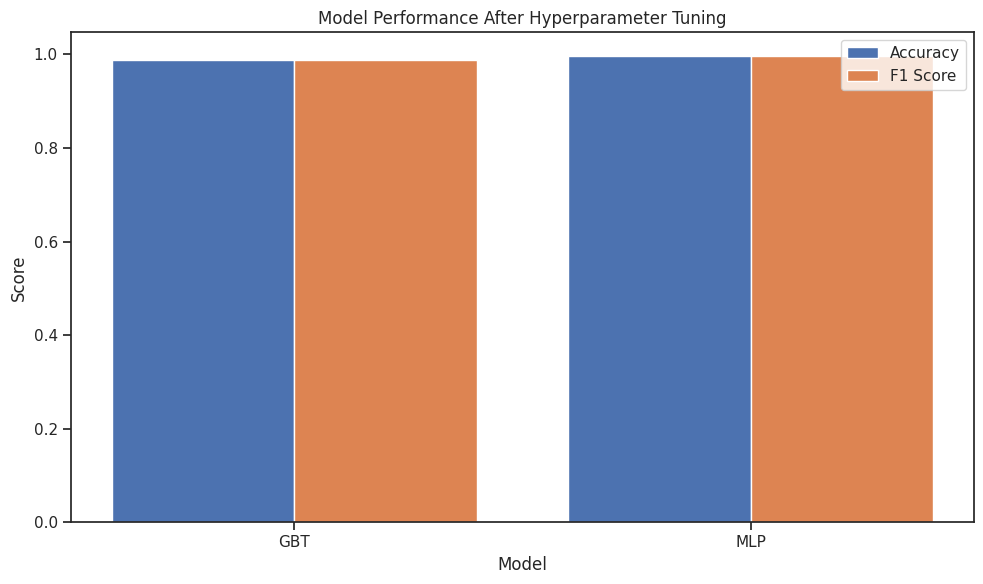

In [ ]:
# --- PLOTTING THE RESULTS ---
plt.figure(figsize=(10, 6))
x = np.arange(len(final_results["Model"]))
plt.bar(x - 0.2, final_results["Best Accuracy"], width=0.4, label="Accuracy")
plt.bar(x + 0.2, final_results["Best F1 Score"], width=0.4, label="F1 Score")

plt.xticks(x, final_results["Model"])
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance After Hyperparameter Tuning")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import when, lag, avg, sum, count
from pyspark.sql.window import Window

In [ ]:
# 1. Analisis Dampak Stres terhadap Performa Akademik

# Membuat kategori stres berdasarkan prediksi probabilitas dari MLP
predictions = mlp_best_model.transform(df_final)

# Join dengan data asli menggunakan tingkat_stres sebagai label
# Pertama kita perlu menyesuaikan kolom untuk join
df_with_label = df.withColumn("label",
    when(col("tingkat_stres") == "Low", 0.0)
    .when(col("tingkat_stres") == "Medium", 1.0)
    .when(col("tingkat_stres") == "High", 2.0)
)


In [ ]:
# Melakukan join
predictions_with_data = predictions.join(df_with_label, on="label")

In [ ]:
# Analisis hubungan stres dengan IPK
stress_gpa_analysis = predictions_with_data.groupBy('prediction').agg(
    avg('ipk').alias('avg_gpa'),
    count('*').alias('count')
).toPandas()


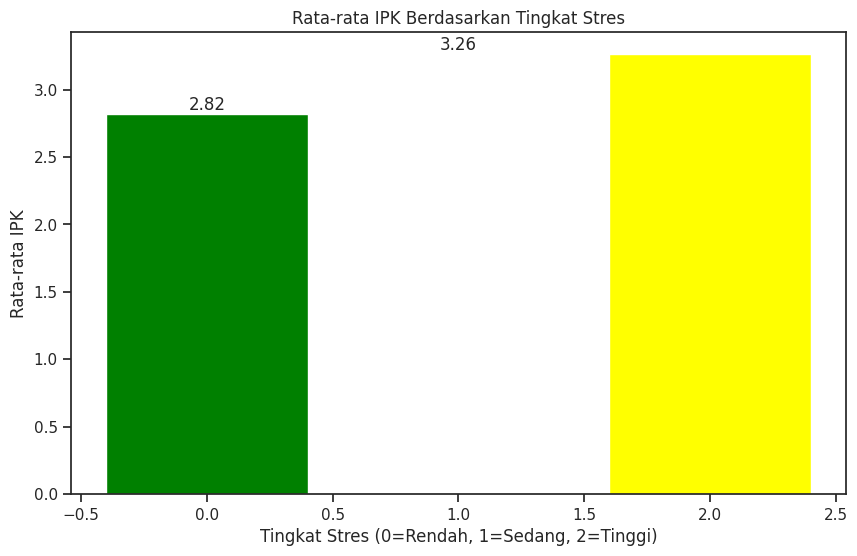

In [ ]:
# Visualisasi dampak stres terhadap IPK
plt.figure(figsize=(10, 6))
plt.bar(stress_gpa_analysis['prediction'], stress_gpa_analysis['avg_gpa'],
        color=['green', 'yellow', 'red'])
plt.title('Rata-rata IPK Berdasarkan Tingkat Stres')
plt.xlabel('Tingkat Stres (0=Rendah, 1=Sedang, 2=Tinggi)')
plt.ylabel('Rata-rata IPK')
for i, v in enumerate(stress_gpa_analysis['avg_gpa']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.show()

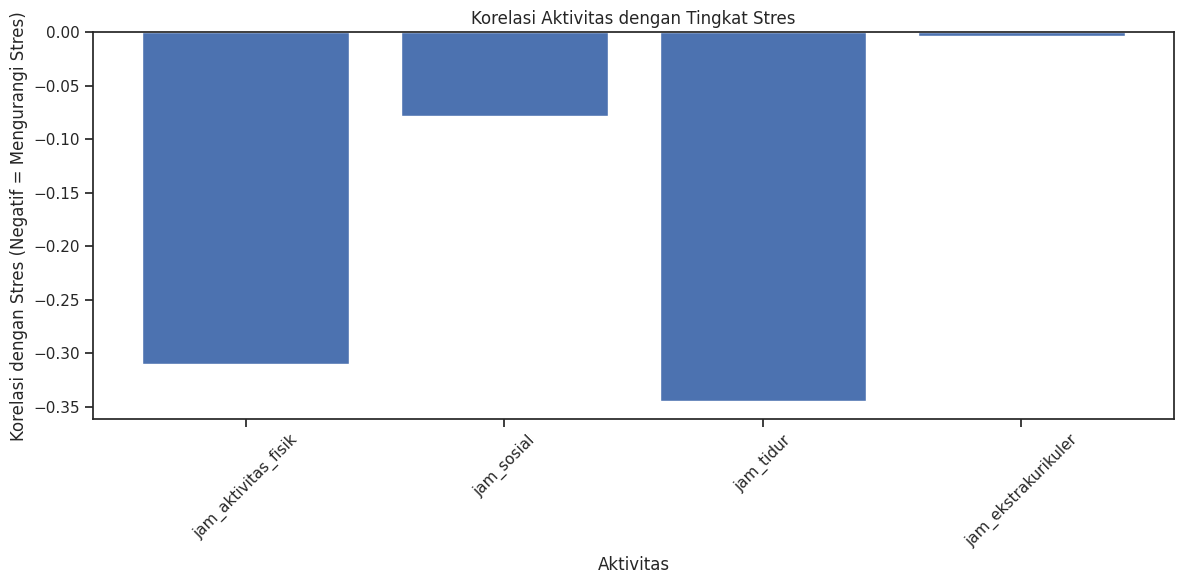

In [ ]:
# 2. Analisis Efektivitas Aktivitas dalam Mengurangi Stres

# Menghitung efektivitas setiap aktivitas
activity_columns = ['jam_aktivitas_fisik', 'jam_sosial', 'jam_tidur', 'jam_ekstrakurikuler']
activity_effectiveness = []

for activity in activity_columns:
    # Menghitung rata-rata tingkat stres untuk setiap level aktivitas
    activity_stats = predictions_with_data.groupBy(activity).agg(
        avg('prediction').alias('avg_stress_level'),
        count('*').alias('count')
    ).toPandas()

    # Menghitung korelasi
    correlation = predictions_with_data.select(activity, 'prediction').toPandas().corr().iloc[0,1]

    activity_effectiveness.append({
        'activity': activity,
        'correlation_with_stress': correlation,
        'stats': activity_stats
    })

activity_effectiveness_df = pd.DataFrame([
    {'activity': x['activity'], 'correlation_with_stress': x['correlation_with_stress']}
    for x in activity_effectiveness
])

# Visualisasi efektivitas aktivitas
plt.figure(figsize=(12, 6))
plt.bar(activity_effectiveness_df['activity'],
        activity_effectiveness_df['correlation_with_stress'])
plt.title('Korelasi Aktivitas dengan Tingkat Stres')
plt.xlabel('Aktivitas')
plt.ylabel('Korelasi dengan Stres (Negatif = Mengurangi Stres)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Print hasil analisis lengkap
print("\nHasil Analisis Impact:")
print("\n1. Dampak Stres terhadap IPK:")
print(stress_gpa_analysis)

print("\n2. Efektivitas Aktivitas dalam Mengurangi Stres:")
print(activity_effectiveness_df)


Hasil Analisis Impact:

1. Dampak Stres terhadap IPK:
   prediction   avg_gpa   count
0         0.0  2.816869  305613
1         2.0  3.261973  305613

2. Efektivitas Aktivitas dalam Mengurangi Stres:
              activity  correlation_with_stress
0  jam_aktivitas_fisik                -0.309431
1           jam_sosial                -0.078134
2            jam_tidur                -0.344041
3  jam_ekstrakurikuler                -0.003873
